# RedCloud Technical Exercise

## Imports and Load data

In [70]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
import mlflow
import mlflow.sklearn

# start mlflow run
run = mlflow.start_run()

# load data
# log dataset name
mlflow.log_param("dataset", "challenge_dataset.csv")
df = pd.read_csv("../data/challenge_dataset.csv")

df

,CustomerID,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Churn
0,55388,5.0,Mobile Phone,1,9.0,Debit Card,4.0,4,Mobile Phone,3.0,3,0.0,15.0,2.0,2.0,4.0,159.77,0.0
1,52565,2.0,Phone,1,15.0,CC,NaN,3,Mobile,3.0,10,0.0,17.0,0.0,1.0,2.0,129.74,0.0
2,50690,13.0,Mobile Phone,1,20.0,Credit Card,2.0,4,Others,3.0,2,0.0,NaN,4.0,4.0,9.0,296.26,0.0
3,52456,NaN,Phone,1,8.0,Debit Card,3.0,3,Mobile,5.0,2,1.0,12.0,1.0,1.0,0.0,120.74,1.0
4,51153,19.0,Mobile Phone,1,8.0,Credit Card,2.0,3,Others,1.0,8,1.0,NaN,1.0,2.0,2.0,293.28,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4656,50385,6.0,Computer,1,12.0,Debit Card,1.0,3,Laptop & Accessory,NaN,4,0.0,23.0,4.0,4.0,7.0,177.25,0.0
4657,52191,13.0,Computer,1,32.0,Credit Card,3.0,4,Laptop & Accessory,1.0,4,1.0,13.0,0.0,1.0,0.0,144.22,0.0
4658,55115,16.0,Computer,1,9.0,Debit Card,3.0,4,Grocery,3.0,2,1.0,NaN,1.0,3.0,11.0,303.61,0.0
4659,55056,5.0,Mobile Phone,1,18.0,Credit Card,4.0,4,Laptop & Accessory,5.0,3,1.0,13.0,2.0,2.0,2.0,193.33,0.0


## Preprocessing

number of customers


In [71]:
df.CustomerID.nunique()

4504

Deduplicate

In [72]:
# deduplicate
df = df.drop_duplicates(subset="CustomerID", keep="first")

# log number of customers
mlflow.log_param("num_customers", df.CustomerID.nunique())

# set CustomerID as index
df = df.set_index("CustomerID")


Look at data types

In [73]:
# get dtypes
df.dtypes

Tenure                         float64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome                float64
PreferredPaymentMode            object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         int64
PreferedOrderCat                object
SatisfactionScore              float64
NumberOfAddress                  int64
Complain                       float64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
CashbackAmount                 float64
Churn                          float64
dtype: object

Dummy encode categorical features

In [74]:
# obj_cols
obj_cols = df.select_dtypes(include=["object"]).columns.values

# num_cols
num_cols = df.select_dtypes(include=["number"]).columns.values

# log number of numerical features
mlflow.log_param("num_numerical_features", len(num_cols))

# log number of categorical features
mlflow.log_param("num_categorical_features", len(obj_cols))

# one hot encode obj_cols
mlflow.log_param("one_hot_encoding", True)
df_obj = pd.get_dummies(df[obj_cols], drop_first=False)

# as int
df_obj = df_obj.astype(int)

# concat
df = pd.concat([df[num_cols], df_obj], axis=1)



Look at missing values

In [75]:

# find cols with missing values
df.isnull().sum().sort_values(ascending=False)


SatisfactionScore                        369
DaySinceLastOrder                        249
OrderAmountHikeFromlastYear              224
Tenure                                   217
WarehouseToHome                          207
OrderCount                               202
HourSpendOnApp                           202
CouponUsed                               195
CashbackAmount                           117
Complain                                  99
Churn                                     26
PreferedOrderCat_Mobile                    0
PreferedOrderCat_Mobile Phone              0
PreferredPaymentMode_Credit Card           0
PreferedOrderCat_Laptop & Accessory        0
PreferedOrderCat_Grocery                   0
PreferedOrderCat_Fashion                   0
PreferredPaymentMode_UPI                   0
PreferredPaymentMode_E wallet              0
PreferredPaymentMode_Debit Card            0
PreferredLoginDevice_Mobile Phone          0
PreferredPaymentMode_Cash on Delivery      0
PreferredP

Fill missing values with median

In [76]:

# fill missing values with median
mlflow.log_param("fill_missing_values", "median")
df = df.fillna(df.median())



Split into features and response

In [77]:
# features
features = df.drop(columns=["Churn"]).columns.values

# log features
mlflow.log_param("features", features)

# response
response = "Churn"

# log response
mlflow.log_param("response", response)



'Churn'

Split into train and test

In [78]:
# shuffle
df = df.sample(frac=1, random_state=42)

# split into train and test
train_df = df.iloc[: int(0.8 * len(df))]
test_df = df.iloc[int(0.8 * len(df)) :]

# log train and test sizes
mlflow.log_param("train_size", len(train_df))
mlflow.log_param("test_size", len(test_df))



901

Scale features

In [79]:
# scale only the features
scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df[features])
test_df_scaled = scaler.transform(test_df[features])

# log scaler
mlflow.log_param("scaler", "StandardScaler")

# to df
train_df_scaled = pd.DataFrame(train_df_scaled, columns=features, index=train_df.index)
test_df_scaled = pd.DataFrame(test_df_scaled, columns=features, index=test_df.index)

# assign response
train_df_scaled[response] = train_df[response]
test_df_scaled[response] = test_df[response]



## Unsupervised Analysis

### t-SNE


t-SNE is a technique to visualize high-dimensional data by giving each point a location in a two-dimensional map. Samples that are close to each other in the t-SNE map are similar to each other. Note however that distances in the t-SNE map are not comparable to distances in the original space (unlike in other methods such as PCA).


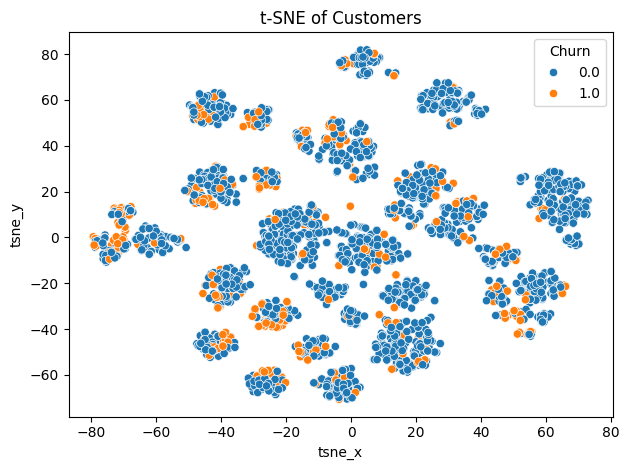

In [80]:
# apply tSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_xy = tsne.fit_transform(train_df_scaled[features])

# assign to df
train_df_scaled["tsne_x"] = tsne_xy[:, 0]
train_df_scaled["tsne_y"] = tsne_xy[:, 1]

# Create the scatter plot
sns.scatterplot(x="tsne_x", y="tsne_y", hue=response, data=train_df_scaled)
plt.title("t-SNE of Customers")

plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("../results/tsne_plot.png")

# Show the plot
plt.show()

# Log the t-SNE plot as an artifact in MLflow
mlflow.log_artifact("../results/tsne_plot.png")



In the scatter plot above, each point represents a customer and is colored by their Churn status. The grouping of the customers uses all features apart from Churn. So customers that are close to each other in the same cluster are customers with very similar profiles. 

## Supervised Analysis

In the supervised analysis the aim is to identify features that seem to be driving response (Churn). And also fit a predictive model (ML model) that can be used to predict Churn for either new or existing customers. This model can also be used to identify the optimal actions to take to retain customers.

### Univariate Analysis

In the univariate analysis we iterate across features, one by one, and compare the distribution of the feature values between positive and negative samples (Churn = 1 or Churn = 0). We perform a statistical test (Mann-Whitney U test) to identify features that have a statistically significant difference in their distribution between positive and negative samples.


In [81]:
### Supervised Analysis

# univariate
# iterate across features and perform mannwhitneyu test with response variable

samples_positive = train_df[train_df[response] == 1].index.values
samples_negative = train_df[train_df[response] == 0].index.values

# log samples positive and negative
mlflow.log_param("samples_positive", samples_positive)
mlflow.log_param("samples_negative", samples_negative)

# log number of samples positive and negative
mlflow.log_param("num_samples_positive", len(samples_positive))
mlflow.log_param("num_samples_negative", len(samples_negative))

# log test as a param
mlflow.log_param("univariate_test", "mannwhitneyu")

univariate_results = []
for feature in features:
    stat, p = mannwhitneyu(
        train_df[feature].loc[samples_positive], train_df[feature].loc[samples_negative]
    )
    fold_change = (
        np.mean(train_df[feature].loc[samples_positive])
        / np.mean(train_df[feature].loc[samples_negative])
    )
    mean_positive = np.mean(train_df[feature].loc[samples_positive])
    mean_negative = np.mean(train_df[feature].loc[samples_negative])
    univariate_results.append((feature, p, fold_change, mean_positive, mean_negative))

# to df
univariate_results = pd.DataFrame(
    univariate_results,
    columns=["feature", "pvalue", "fold_change", "mean_positive", "mean_negative"],
)

# sort by p-value
univariate_results = univariate_results.sort_values(by="pvalue")

# assign phred score
univariate_results["phred"] = -np.log10(univariate_results["pvalue"])

# plot using Plotly
univariate_results['color'] = univariate_results['fold_change'].apply(lambda x: 'high in churn' if x > 1 else 'low in churn')

# save univariate results
univariate_results.to_csv("../results/univariate_results.csv")

# log univariate results
mlflow.log_artifact("../results/univariate_results.csv")


fig = px.bar(
    univariate_results,
    x="phred",
    y="feature",
    orientation='h',
    color='color',
    color_discrete_map={'high in churn': 'red', 'low in churn': 'blue'},
    labels={"color": "Churn Level"},
    width=800,
    height=800,
)
# add title
fig.update_layout(title="Univariate Analysis of Features")
fig.show()

# save univariate plot
fig.write_image("../results/univariate_plot.png")

# log univariate plot
mlflow.log_artifact("../results/univariate_plot.png")   



In the bar plot above, each bar represents a feature and is colored red if it is higher in average in the positive samples (Churn = 1) and blue if it is higher in the negative samples (Churn = 0). The bar size is proportional to the phred score which indicates statistical significance based on the Mann-Whitney U test.

See also below the univariate results in more detail.

In [82]:
univariate_results

,feature,pvalue,fold_change,mean_positive,mean_negative,phred,color
0,Tenure,7.317080e-101,0.383965,4.375212,11.394824,100.135662,low in churn
7,Complain,2.513199e-50,2.338400,0.522920,0.223623,49.599773,high in churn
11,DaySinceLastOrder,5.668561e-32,0.649819,3.089983,4.755143,31.246527,low in churn
27,PreferedOrderCat_Mobile Phone,2.328725e-25,2.023680,0.385399,0.190445,24.632882,high in churn
12,CashbackAmount,3.071534e-24,0.888404,160.341834,180.482983,23.512645,low in churn
25,PreferedOrderCat_Laptop & Accessory,1.212488e-15,0.552968,0.213922,0.386861,14.916323,low in churn
5,SatisfactionScore,2.208080e-11,1.134301,3.387097,2.986065,10.655985,high in churn
14,PreferredLoginDevice_Mobile Phone,7.694287e-11,0.714482,0.366723,0.513271,10.113832,low in churn
4,NumberOfDeviceRegistered,1.415001e-10,1.087739,3.945671,3.627405,9.849243,high in churn
24,PreferedOrderCat_Grocery,3.173439e-09,0.179900,0.015280,0.084937,8.498470,low in churn


### Classification Modelling

In Classification modelling we train a classifier to predict Churn based on the other features in the dataset. We tried several models and landed on a RandomForestClassifier or GradientBoostingClassifier with 100 trees. 

The classifier is trained on the training set and then its performance is evaluated on both the training and test sets. We always expect a drop in performance on the test set compared to the training set, since these tree based classifiers tend to remember the training set. Nevertheless is the performance on the test set still good, we consider the model to be a good fit.

To quantify the performance of the model we use the ROC AUC metric. The AUC score ranges between 0 and 1. A model that predicts perfectly would have an AUC of 1 and a model that predicts randomly would have an AUC of 0.5.

Finally from the ML model we can identify the most important features that drive Churn. These features can give us insights into the optimal actions to take to retain customers.

Train model

In [83]:
# classification modelling

# log classification model
mlflow.log_param("classification_model", "RandomForestClassifier")

# RF classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
# GB classifier
# rf = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)


rf.fit(train_df_scaled[features], train_df_scaled[response])

# log number of trees
mlflow.log_param("num_trees", 100)

# log max depth
mlflow.log_param("max_depth", 10)

# Log the RandomForest model
mlflow.sklearn.log_model(rf, "random_forest_model")



2024/12/03 16:31:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


calculate performance on training set

In [84]:
# predict on train set
train_predictions = rf.predict_proba(train_df_scaled[features])[:, 1]

# to df
train_predictions = pd.DataFrame(train_predictions, columns=["prediction"], index=train_df_scaled.index)

# assign response
train_predictions[response] = train_df_scaled[response]

# plot ROC curve
fpr, tpr, thresholds = roc_curve(train_predictions[response], train_predictions["prediction"])
roc_auc = auc(fpr, tpr)

print(f"ROC AUC on training set: {roc_auc}")

ROC AUC on training set: 0.9974150061456271


Calculate performance on test set

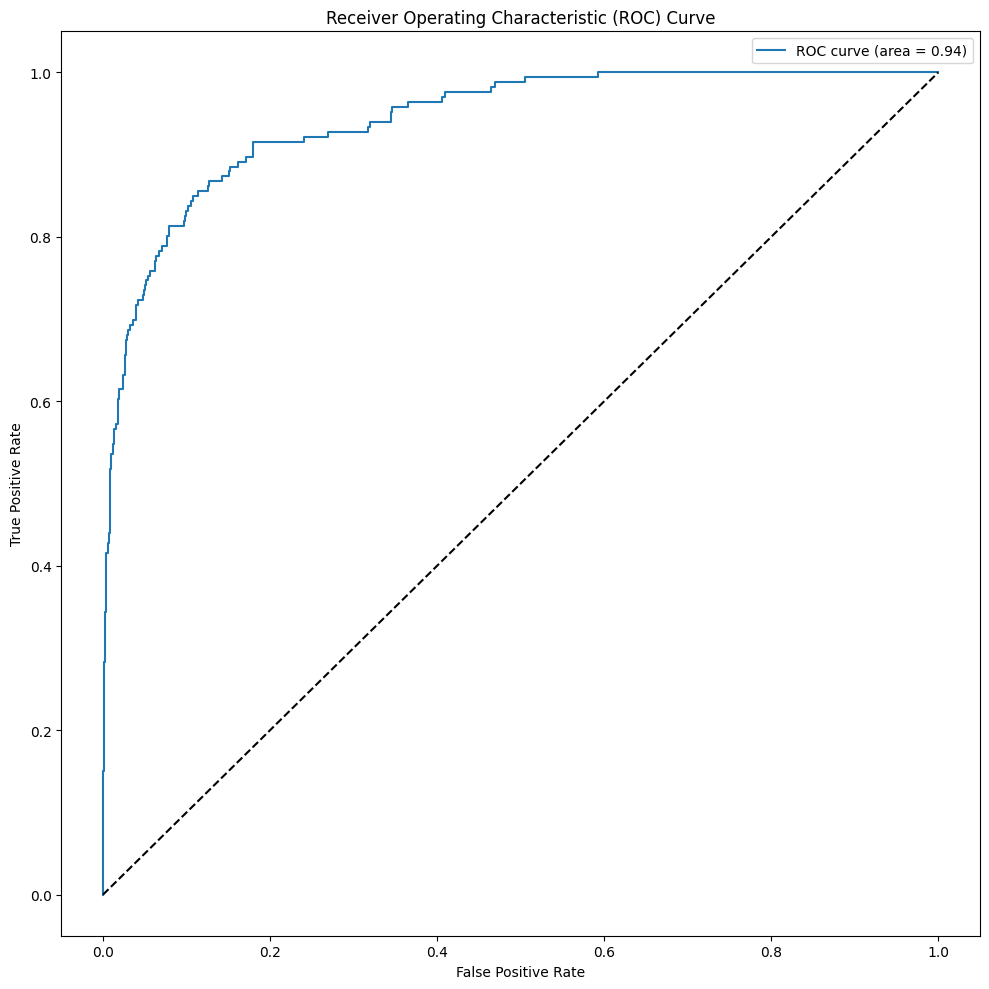

In [85]:

# predict on test set
test_predictions = rf.predict_proba(test_df_scaled[features])[:, 1]

# to df
test_predictions = pd.DataFrame(test_predictions, columns=["prediction"], index=test_df_scaled.index)

# assign response
test_predictions[response] = test_df_scaled[response]

# save test predictions
test_predictions.to_csv("../results/test_predictions.csv")

# log test predictions
mlflow.log_artifact("../results/test_predictions.csv")

# plot ROC curve
fpr, tpr, thresholds = roc_curve(test_predictions[response], test_predictions["prediction"])
roc_auc = auc(fpr, tpr)

# log roc auc
mlflow.log_metric("roc_auc_test", roc_auc)

# plot
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()

plt.tight_layout()


# save roc curve
plt.savefig("../results/roc_curve.png")

plt.show()

# log roc curve
mlflow.log_artifact("../results/roc_curve.png")



Calculate feature importance

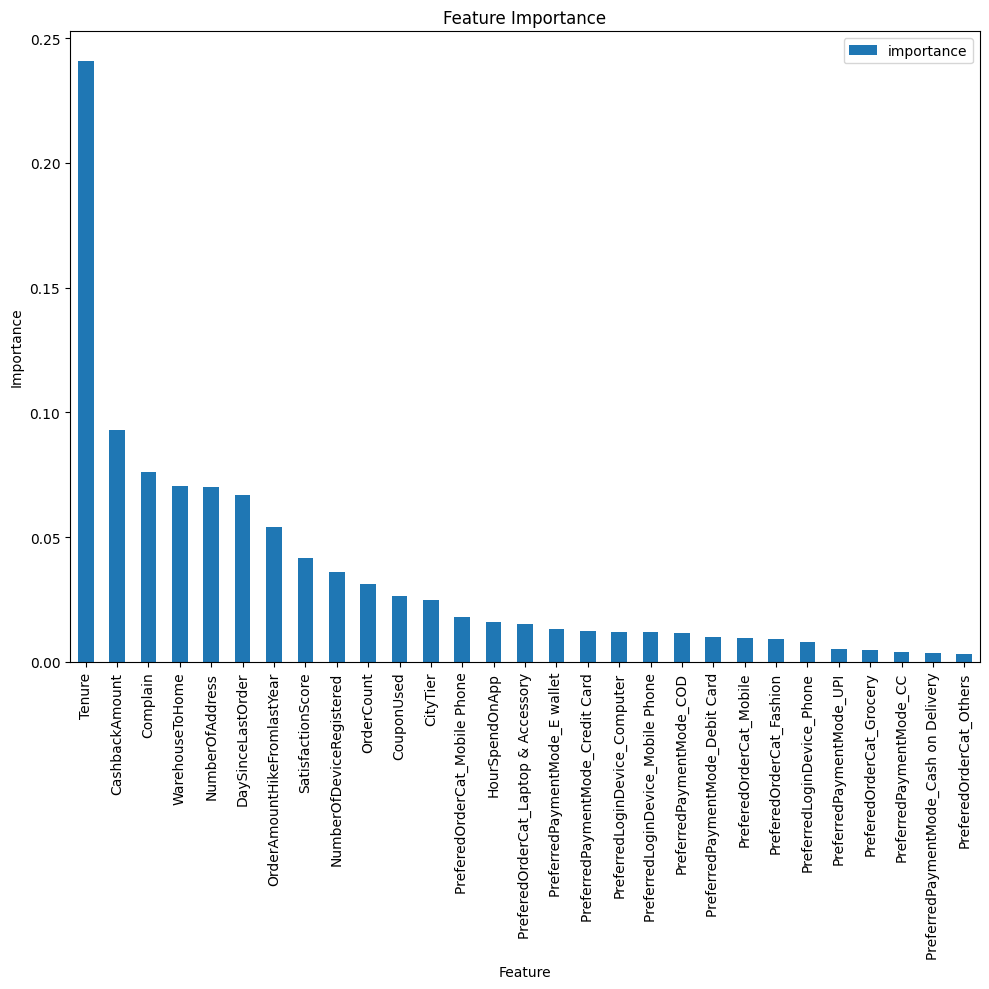

In [86]:
# feature importance
feature_importance = pd.DataFrame(rf.feature_importances_, index=features, columns=["importance"])
feature_importance = feature_importance.sort_values(by="importance", ascending=False)
feature_importance.plot(kind="bar", figsize=(10, 10))
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")

plt.tight_layout()


# save feature importance figure
plt.savefig("../results/feature_importance.png")

plt.show()

# log feature importance
feature_importance.to_csv("../results/feature_importance.csv")

# log feature importance
mlflow.log_artifact("../results/feature_importance.csv")

# log feature importance figure
mlflow.log_artifact("../results/feature_importance.png")



### Recursive Feature Elimination

A lot of the features in the dataset are highly correlated with each other. Actually many of them reflect the response variable (Churn) or the overall customer experience, e.g. the number of complaints, Tenure, Cashback etc. These features are essentially proxies for the response variable, and shed little light on the underlying drivers of Churn, offering few actionable insights.

To address this we perform Recursive Feature Elimination (RFE) to identify the minimum set of non-redundant features that are most important for predicting Churn, and ideally also offer actionable insights.

The approach is as follows:
1. Fit a RandomForestClassifier on all features and calculate the ROC AUC on the test set.
2. Remove the feature with the highest correlation with the other features in the dataset.
3. Fit a RandomForestClassifier on the remaining features and calculate the ROC AUC on the test set.
4. Repeat steps 2 and 3 until the AUC drops below a certain threshold.

In [87]:


### Find minimum set of non-redundant features

# log minimum set of non-redundant features
mlflow.log_param("minimum_set_of_non_redundant_features", True)

# use correlation
use_correlation = True 

# log use correlation
mlflow.log_param("use_correlation", use_correlation)

if use_correlation:
    # calculate feature correlation matrix
    feature_correlation = train_df_scaled[features].corr()

    # recursively remove features with highest correlation until no features are removed, as long as the AUC doesn't decrease by more than 5%
    removed_features = []
    start_auc = roc_auc
    while True:

        most_correlated_feature = feature_correlation.drop(index=removed_features).drop(columns=removed_features).abs().sum(axis=1).sort_values(ascending=False).index[0]
        removed_features.append(most_correlated_feature)

        # fit RF classifier
        rf.fit(train_df_scaled[features].drop(columns=removed_features), train_df_scaled[response])
        # predict on test set
        test_predictions = rf.predict_proba(test_df_scaled[features].drop(columns=removed_features))[:, 1]
        # calculate AUC
        fpr, tpr, thresholds = roc_curve(test_df_scaled[response], test_predictions)
        new_auc = auc(fpr, tpr)

        if new_auc < 0.8:
            break

else: 
    # use feature importance to remove features
    # iterate across features, remove the least important feature until AUC drops to 0.8
    removed_features = []
    start_auc = roc_auc
    while True:

        weakest_feature = feature_importance.drop(index=removed_features).sort_values(by="importance").index[0]
        removed_features.append(weakest_feature)

        # fit RF classifier
        rf.fit(train_df_scaled[features].drop(columns=removed_features), train_df_scaled[response])

        # predict on test set
        test_predictions = rf.predict_proba(test_df_scaled[features].drop(columns=removed_features))[:, 1]
        # calculate AUC
        fpr, tpr, thresholds = roc_curve(test_df_scaled[response], test_predictions)
        new_auc = auc(fpr, tpr)

        if new_auc < 0.85:
            break

# kept features
kept_features = list(set(features) - set(removed_features))

# log kept features
mlflow.log_param("kept_features", kept_features)

print(f"Kept features: {kept_features}")



Kept features: ['WarehouseToHome', 'PreferredPaymentMode_UPI', 'DaySinceLastOrder', 'PreferredLoginDevice_Computer', 'NumberOfDeviceRegistered', 'SatisfactionScore']


Fit model on kept features


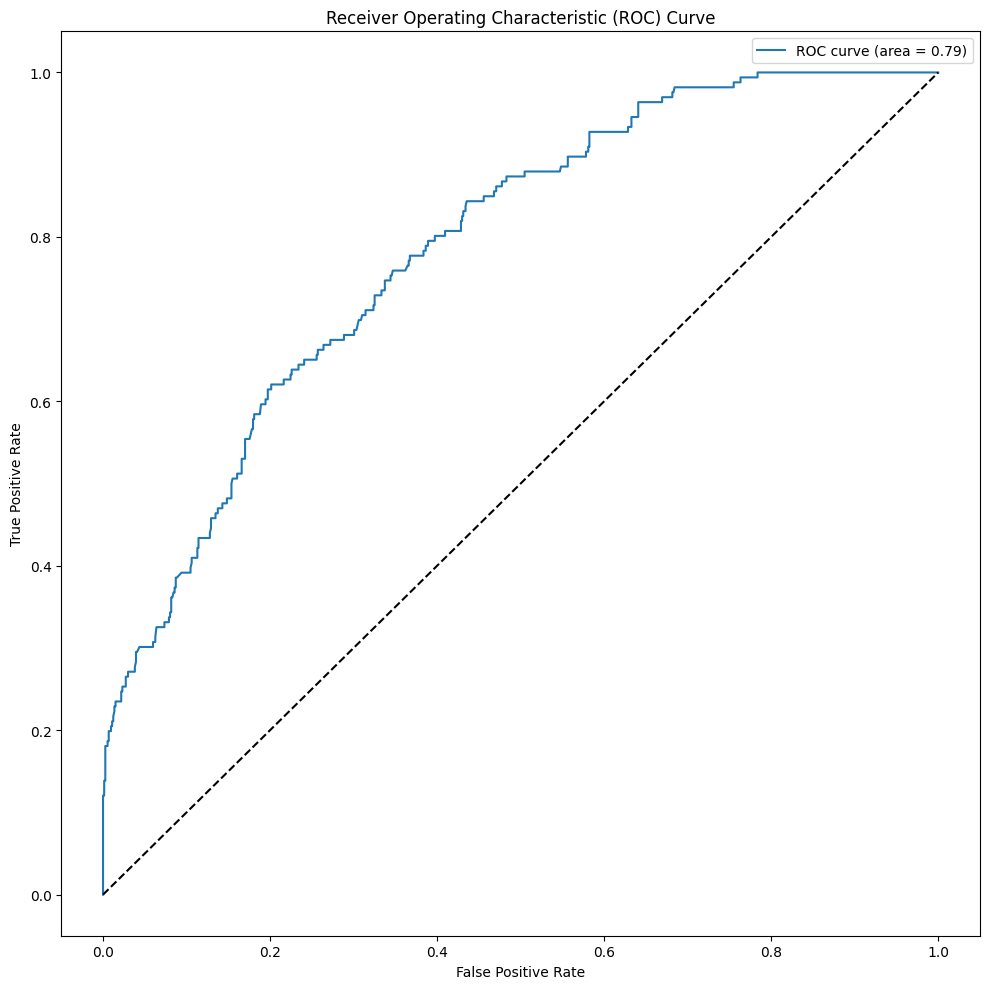

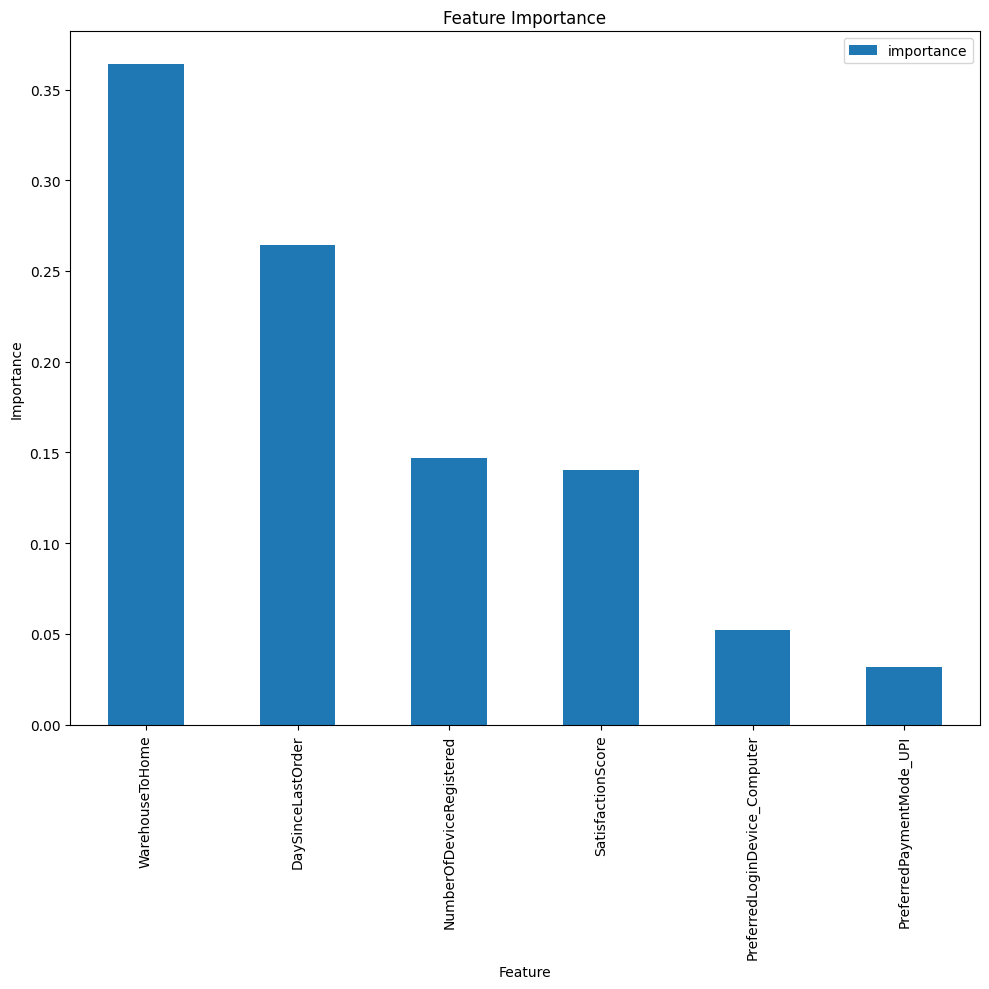

In [88]:
# fit RF classifier on kept features
rf.fit(train_df_scaled[kept_features], train_df_scaled[response])

# predict on test set
test_predictions = rf.predict_proba(test_df_scaled[kept_features])[:, 1]

# calculate AUC
fpr, tpr, thresholds = roc_curve(test_df_scaled[response], test_predictions)
roc_auc = auc(fpr, tpr)

# log roc auc
mlflow.log_metric("roc_auc_test_non_redundant", roc_auc)

# plot
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()

plt.tight_layout()


# save roc curve
plt.savefig("../results/roc_curve_non_redundant.png")

plt.show()

# log roc curve
mlflow.log_artifact("../results/roc_curve_non_redundant.png")

# feature importance
feature_importance = pd.DataFrame(rf.feature_importances_, index=kept_features, columns=["importance"])
feature_importance = feature_importance.sort_values(by="importance", ascending=False)
feature_importance.plot(kind="bar", figsize=(10, 10))
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")

plt.tight_layout()


# save feature importance figure
plt.savefig("../results/feature_importance_non_redundant.png")

plt.show()

# log feature importance figure
mlflow.log_artifact("../results/feature_importance_non_redundant.png")



We observe the top feature now (Distance of warehouse from customer) is more actionable than before. This probabably tells us the customers that churn are those that are further away from the warehouse. Maybe one action could be to offer priority shipping to these customers.

## Sensitivity Analysis


Here we perturb the feature values and monitor the change in the predicted probability an average customer churns. This way we can identify the actions we can take that are most likely to reduce churn and retain customers.

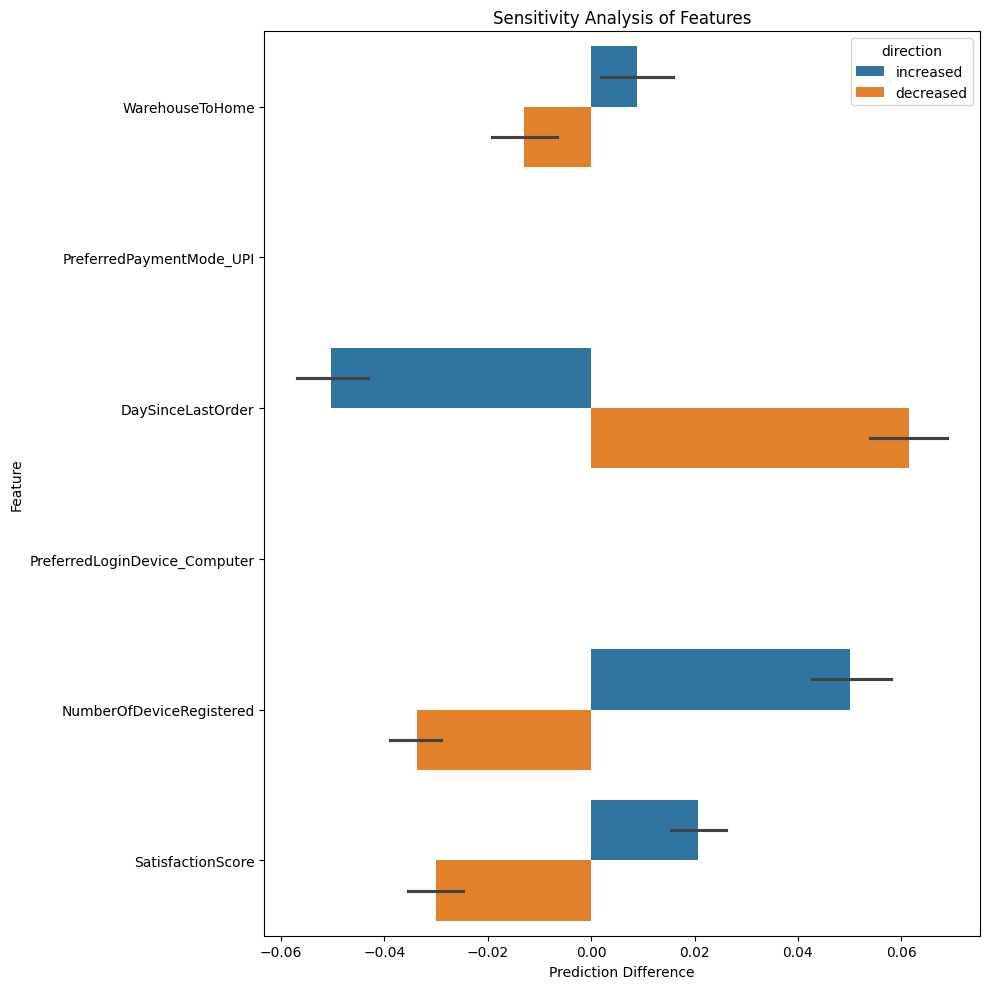

In [89]:
### sensitivity analysis 

# iterate across features, increase or decrease feature values by 20% and calculate predicted probabilities
sensitivity_results = []
# feature = 'Complain'
for feature in kept_features:
    # increase
    increased_feature = test_df_scaled[feature] + 0.5
    # predict
    increased_predictions = rf.predict_proba(test_df_scaled[kept_features].drop(columns=[feature]).assign(**{feature: increased_feature})[kept_features])[:, 1]
    # to df
    increased_predictions = pd.DataFrame(increased_predictions, columns=["prediction"], index=test_df_scaled.index)
    # assign response
    increased_predictions[response] = test_df_scaled[response]
    # assign feature name
    increased_predictions["feature"] = feature
    # assign direction
    increased_predictions["direction"] = "increased"

    # same for decreased
    decreased_feature = test_df_scaled[feature] - 0.5
    decreased_predictions = rf.predict_proba(test_df_scaled[kept_features].drop(columns=[feature]).assign(**{feature: decreased_feature})[kept_features])[:, 1]
    # to df
    decreased_predictions = pd.DataFrame(decreased_predictions, columns=["prediction"], index=test_df_scaled.index)
    # assign response
    decreased_predictions[response] = test_df_scaled[response]
    # assign feature name
    decreased_predictions["feature"] = feature
    # assign direction
    decreased_predictions["direction"] = "decreased"

    # append
    sensitivity_results.append(increased_predictions)
    sensitivity_results.append(decreased_predictions)

# to df
sensitivity_results = pd.concat(sensitivity_results)

# predictions on original data
original_predictions = rf.predict_proba(test_df_scaled[kept_features])[:, 1]
original_predictions = pd.DataFrame(original_predictions, columns=["prediction"], index=test_df_scaled.index)
original_predictions[response] = test_df_scaled[response]

# rename prediction column
sensitivity_results = sensitivity_results.rename(columns={"prediction": "prediction_perturbed"})

# reset index
sensitivity_results = sensitivity_results.reset_index()
original_predictions = original_predictions.reset_index()

# merge
sensitivity_results = pd.merge(sensitivity_results, original_predictions.drop(columns=["Churn"]), on=["CustomerID"])

# calculate prediction difference
sensitivity_results["prediction_diff"] = sensitivity_results["prediction_perturbed"] - sensitivity_results["prediction"]

# calculate absolute prediction difference
sensitivity_results["prediction_diff_abs"] = sensitivity_results["prediction_diff"].abs()

# save sensitivity results
sensitivity_results.to_csv("../results/sensitivity_results.csv")

# log sensitivity results
mlflow.log_artifact("../results/sensitivity_results.csv")

# log sensitivity plot
mlflow.log_artifact("../results/sensitivity_plot.png")

# same but using prediction_diff
# figsize
plt.figure(figsize=(10, 10))
sns.barplot(x="prediction_diff", y="feature", data=sensitivity_results, orient="h", hue="direction")
plt.title("Sensitivity Analysis of Features")
plt.xlabel("Prediction Difference")
plt.ylabel("Feature")

plt.tight_layout()

# save sensitivity plot
plt.savefig("../results/sensitivity_plot_prediction_diff.png")

plt.show()

# log sensitivity plot
mlflow.log_artifact("../results/sensitivity_plot_prediction_diff.png")



In the figure above, bars in the negative direction indicate the average customer is less likely to churn, and bars in the positive direction indicate the average customer is more likely to churn. The color of the bars indicates the feature change that results in the observed change in churn probability. Blue bars indicate that the feature value was increased, and orange bars indicate that the feature value was decreased.

E.g. Reducing the Distance of warehouse from the customer is expected to reduce churn by 1 to 2% on average. On the other hand, increasing the Distance of warehouse from the customer is expected to increase churn by 1 to 2% on average.

## End run

In [90]:
mlflow.end_run()

